In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf 
import os 
import numpy as np  
from google.colab import drive

SEED= 10491539
tf.random.set_seed(SEED)

cwd= os.getcwd() #get current working directory 

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.applications.vgg16 import preprocess_input 

apply_data_augmentation  = True

if  apply_data_augmentation:
  train_datagen = ImageDataGenerator(             #this data augmentation is gonna modify the images at each epoch 
  width_shift_range = 0.2, 
  height_shift_range = 0.2,
  vertical_flip=True,
  shear_range = 0.2,
  horizontal_flip=True,
  rotation_range=10,
  fill_mode='constant',
  cval=0,
  rescale=1/255,   
  preprocessing_function=preprocess_input)
  
else:
  train_datagen = ImageDataGenerator(rescale=1/255,preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(rescale=1/255,preprocessing_function=preprocess_input)
test_datagen= ImageDataGenerator(rescale=1/255,preprocessing_function=preprocess_input)


In [18]:

#now I need to get the test images and associate them to the label contained in the json file 
import pandas as pd
import json
import sklearn

json_path=os.path.join(cwd,'drive','My Drive','MaskDataset')

with open(os.path.join(json_path,"train_gt.json")) as j:
  tmp = json.load(j)

train_df = pd.DataFrame(tmp.items())
train_df.rename(columns = {0:'filename', 1:'class'}, inplace = True)
train_df["class"] = train_df["class"].astype(str)

train_df_shuffled=sklearn.utils.shuffle(train_df) #here we could divide the dataset in training and validation

training_df= train_df_shuffled[614:]
validation_df= train_df_shuffled[:614]

print(validation_df,training_df)

       filename class
28    17170.jpg     0
1905  12991.jpg     1
827   13433.jpg     0
2269  10049.jpg     1
3942  17929.jpg     2
...         ...   ...
2766  16028.jpg     1
3926  17491.jpg     2
2912  17210.jpg     1
4710  13286.jpg     2
5248  17429.jpg     2

[614 rows x 2 columns]        filename class
4637  17060.jpg     2
2833  12390.jpg     1
1680  16462.jpg     0
1836  16632.jpg     0
1190  11470.jpg     0
...         ...   ...
574   14910.jpg     0
2780  12926.jpg     1
2325  14937.jpg     1
3092  17593.jpg     1
4248  14271.jpg     2

[5000 rows x 2 columns]


In [19]:
#Let's create the generators 

directory_training =os.path.join(cwd,'drive','My Drive','MaskDataset','training')


bs = 16

train_generator=train_datagen.flow_from_dataframe(
dataframe=training_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,
shuffle=True,
class_mode="categorical",
)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=validation_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,
shuffle=True,
class_mode="categorical",
)

Found 5000 validated image filenames belonging to 3 classes.
Found 614 validated image filenames belonging to 3 classes.


In [20]:
num_classes=3
img_h=256
img_w=256


train_dataset= tf.data.Dataset.from_generator(lambda:train_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes])) 

train_dataset=train_dataset.repeat()

validation_dataset= tf.data.Dataset.from_generator(lambda:valid_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes]))


validation_dataset=validation_dataset.repeat()


[]

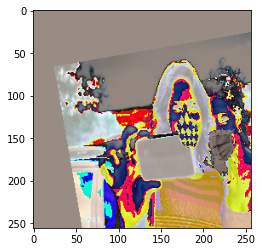

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

iterator= iter(train_dataset)

img , target = next(iterator)
img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

[]

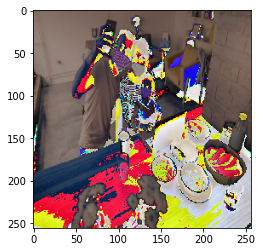

In [22]:
%matplotlib inline

iterator= iter(validation_dataset)

img , target = next(iterator)

img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

In [23]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

In [24]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [25]:


finetuning = True

if finetuning:
    freeze_until = 15 # layer from which we want to fine-tune
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False
    
model = tf.keras.Sequential()
model.add(vgg)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# Visualize created model as a table
model.summary()

# Visualize initialized weights
model.weights

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 31,493,955
Trainable params: 23,858,691
Non-trainable params: 7,635,264
_________________________________________________________________


[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
    

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 31,493,955
Trainable params: 23,858,691
Non-trainable params: 7,635,264
_________________________________________________________________


In [27]:
loss= tf.keras.losses.CategoricalCrossentropy()

lr= 1e-4

optimizer= tf.keras.optimizers.Adam(learning_rate=lr)

metrics=['accuracy']

model.compile(optimizer=optimizer,loss=loss,metrics=metrics )

In [28]:
#lets do early stopping callback 


callbacks=[]

es_callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True,patience = 10) 
callbacks.append(es_callback)
    
test_dir =os.path.join(cwd,'drive','My Drive')

#tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
#                                             profile_batch=0,
#                                             histogram_freq=1)  # if 1 shows weights histograms
#callbacks.append(tb_callback)

model.fit(x=train_dataset, 
          epochs=100,  #max number of epoch 
          steps_per_epoch=len(train_generator),
          validation_data= validation_dataset, 
          validation_steps=len(valid_generator),
          callbacks=callbacks )

Epoch 1/100
313/313 [==============================] - 105s 335ms/step - loss: 0.8078 - accuracy: 0.5908 - val_loss: 0.5921 - val_accuracy: 0.7215
Epoch 2/100
313/313 [==============================] - 104s 332ms/step - loss: 0.6163 - accuracy: 0.7060 - val_loss: 0.5045 - val_accuracy: 0.7671
Epoch 3/100
313/313 [==============================] - 104s 331ms/step - loss: 0.5442 - accuracy: 0.7440 - val_loss: 0.4526 - val_accuracy: 0.8078
Epoch 4/100
313/313 [==============================] - 103s 330ms/step - loss: 0.4925 - accuracy: 0.7706 - val_loss: 0.4505 - val_accuracy: 0.8143
Epoch 5/100
313/313 [==============================] - 103s 328ms/step - loss: 0.4595 - accuracy: 0.8000 - val_loss: 0.4194 - val_accuracy: 0.8127
Epoch 6/100
313/313 [==============================] - 102s 325ms/step - loss: 0.4181 - accuracy: 0.8170 - val_loss: 0.4100 - val_accuracy: 0.8257
Epoch 7/100
313/313 [==============================] - 102s 324ms/step - loss: 0.3818 - accuracy: 0.8354 - val_loss: 0

In [30]:
test_dir =os.path.join(cwd,'drive','My Drive','MaskDataset','test')

test_gen = test_datagen.flow_from_directory(test_dir, target_size=(img_h, img_w), 
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 classes = None,
                                                 batch_size=1,
                                                 shuffle=False)
test_gen.reset()

predictions = model.predict_generator(test_gen, len(test_gen), verbose=1)


from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

results = {}
images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
create_csv(results, '/content/drive/My Drive')

Found 450 images belonging to 1 classes.
450/450 [==============================] - 4s 9ms/step
